<a href="https://colab.research.google.com/github/gowtham66866/Inkers/blob/master/Gowtham_Assignment_1_EIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ls
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


#### Training resnet18 model for 200 epochs with 128 batch size, and saved the best model, in google drive.

The keras python file for building model and training it is located in google colab. which is excuted from colab. We can see the training verbose, below.
Achieved an accuracy of 90.83% on test data set of the cifar10.

In [0]:
# !python /content/gdrive/My\ Drive/resnet18_cifar10.py

#### Loaded cifar10 dataset, into train and test split of 50k and 10k samples respectively.

After that, load the best keras model from the google drive, saved while training above.

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()

In [7]:
from keras.models import load_model
model = load_model('/content/gdrive/My Drive/cifar10_ResNet20v1_model.133.h5')

W0721 06:26:05.283790 140661617964928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 06:26:05.352448 140661617964928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0721 06:26:05.409110 140661617964928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 06:26:05.410649 140661617964928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0721 06:26:05.41179

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
import numpy as np
import matplotlib.pyplot as plt

j,t = 0, 0
X_test_wrong = []
X_test_wrong_raw = []
for i in range(len(test_features)):
  img_data = test_features[i].astype('float32')
  img_data /= 255
  img_data = np.expand_dims(img_data, axis=0)
#   img_data = test_features[i].reshape(1, 32, 32,3)
  t += 1
#   print(model.predict(img_data)[0])
#   print(np.argmax(model.predict(img_data)[0]))
#   print(test_labels[i][0])
  if np.argmax(model.predict(img_data)[0]) != test_labels[i][0]:
    X_test_wrong.append((img_data, np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    X_test_wrong_raw.append((test_features[i], np.argmax(model.predict(img_data)[0]), test_labels[i][0]))
    j += 1
  if j >= 50:
    break
print('totla false preds {} for samples {}'.format(j,t))

totla false preds 50 for samples 342


In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

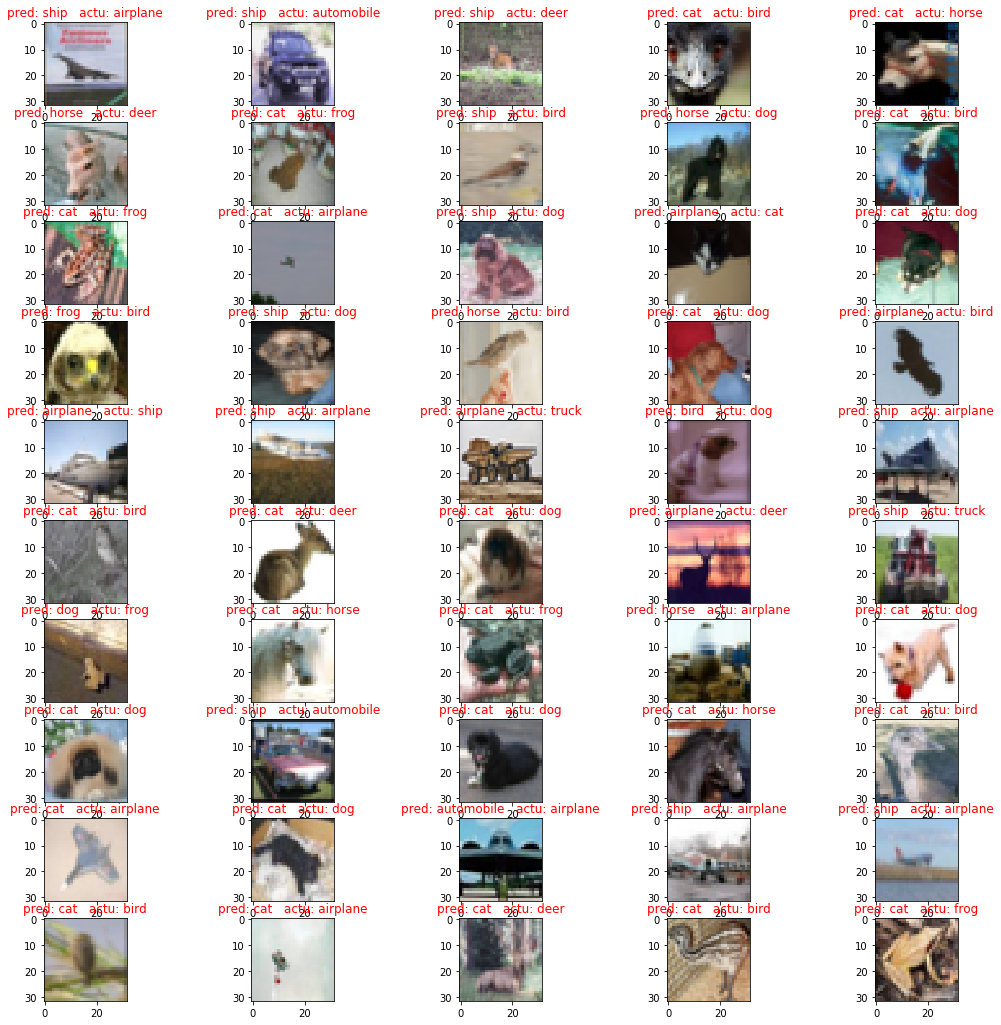

In [11]:
plt.figure(figsize=(18,18))
batch_size = 25
i = 0
for img in X_test_wrong:
  ax = plt.subplot(10,5,i+1)
  ax.set_title("pred: {}   actu: {}".format(class_names[img[1]], class_names[img[2]]), color='r')
  plt.imshow(np.reshape(np.uint8(255 * img[0]), (32,32,-1)), cmap=plt.cm.gray)
  i += 1

In [0]:

%matplotlib inline
import cv2
import keras.backend as K

def grad_CAM(img):
    img = img.astype('float32')
    img /= 255
    x = np.expand_dims(img, axis=0)
#     x = preprocess_input(x)


    preds = model.predict(x)  #model
#     print("no cutout")
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]  #moel
    last_conv_layer = model.get_layer("conv2d_21")   # model



    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([x])
    for i in range(64):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]


    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    img = np.uint8(255 * img)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    return superimposed_img, preds

grad CAM for 50 mis-classified images is shown below.
**Some observations:**


1.   In some images the model is not seeing at the object, leading to mis classification
2.   In other images it is looking at only part of the image and assuming it to be some thing else, leading to false classification.
3.  In other images it looks at the object in the image, but assumes it to be something else, due to the object being very similar to some other class object in the data set. And other reason could be, the object in the image is not clear and the features are not clearly distinguashable for the model.




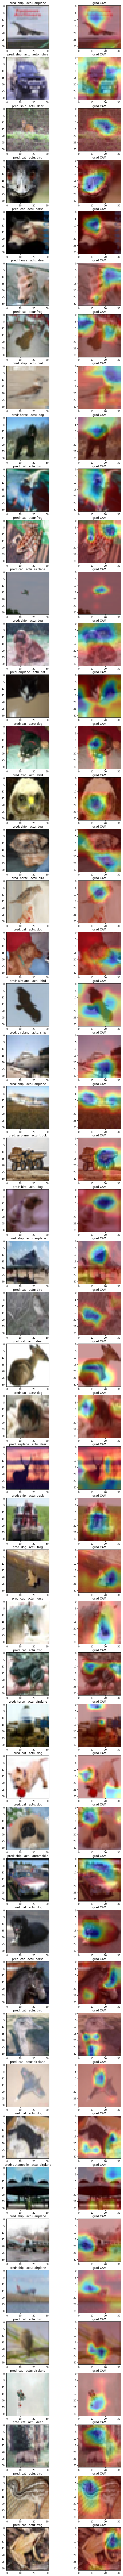

In [13]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
%matplotlib inline
fig, ax = plt.subplots(50,2,figsize=(10, 200))
for k,l in enumerate(X_test_wrong_raw[:]):
  
  superimposed_img, preds = grad_CAM(l[0])
  
  ax[k,0].imshow(l[0])
  ax[k,0].set_title("pred: {}   actu: {}".format(class_names[l[1]], class_names[l[2]]))
  ax[k,1].imshow(superimposed_img)
  ax[k,1].set_title("grad CAM")
  